## **Anomaly Detection and Association Analysis**


You will implement some of the Anomaly Detection algorithms we have covered in lecture from scratch and then you will dive into demonstarting your understanding of Association Analysis.






## **Part 1: Anomaly Detection**

### **Q1 Proximity-Based Anomaly Detection**

You will implement a method that calculates the Euclidean distance between each point in a dataset to all other points, identifies the minimum distance (i.e., the distance to the nearest neighbor), and then flags any points as anomalies if their nearest neighbor distance is more than a specified number of standard deviations away from the mean of these distances.

In [ ]:
from math import sqrt

def euclidean_distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    return sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))

In [ ]:
import numpy as np
def proximity_based_anomaly_detection(data, threshold=2):

    """
    Detects anomalies in a dataset based on the proximity to the nearest neighbor.

    Parameters:
    - data (list of list of floats): The dataset to analyze, where each sub-list represents a data point in multi-dimensional space.
    - threshold (float): The number of standard deviations away from the mean distance to flag an anomaly.

    Returns:
    - list of bool: A list where each element corresponds to a data point. True for anomalies, False for normal points.
    """

    # Calculate the distance from each point to its nearest neighbor and add them
    # to the nearest neighbor distances list
    nearest_neighbor_distances = []
    for i, point in enumerate(data):
        distances = [np.linalg.norm(np.array(point) - np.array(other_point)) for j, other_point in enumerate(data) if i != j]
        nearest_neighbor_distances.append(min(distances))

    # Calculate the mean and standard deviation of the nearest neighbor distances
    mean_distance = np.mean(nearest_neighbor_distances)
    std_distance = np.std(nearest_neighbor_distances)

    # Flag points as anomalies if their distance to the nearest neighbor is greater than the threshold
    anomalies = [distance > mean_distance + threshold * std_distance for distance in nearest_neighbor_distances]
    return anomalies

# Example usage with a simple 2D dataset:
example_data = [
    [1, 1],
    [2, 2],
    [1, 2],
    [2, 1],
    [100, 100]  # This point is an anomaly
]

# Detect anomalies
anomalies_detected = proximity_based_anomaly_detection(example_data, threshold=1)
print(anomalies_detected)


[False, False, False, False, True]


In [ ]:
anomalies_detected

[False, False, False, False, True]

### **Q2 Density-Based Anomaly Detection**

Implement the density based anomaly detection algorithm. This function should calculate the local density of data points and compare it to the density of its neighbors. Points that lie in regions of low density compared to their neighbors are marked as anomalies.



* Implement a function that calculates the local density for each data point and compares it to the average density of its neighbors. Points that lie in regions of significantly lower density compared to their neighbors are flagged as anomalies. The implementation uses Euclidean distance to measure proximity within a specified radius.
        

In [ ]:
from math import sqrt

def local_density(center_point, data, radius):
    """Calculate the local density of a point given a radius."""
    return sum(1 for point in data if euclidean_distance(center_point, point) <= radius)

def euclidean_distance(point1, point2):
    return sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))


In [ ]:
def density_based_anomaly_detection(data, radius=1.0, threshold=2):
    """
    Detects anomalies in a dataset based on the local density of data points and the density of their neighbors.

    Parameters:
    - data (list of list of floats): The dataset to analyze, where each sub-list represents a data point in multi-dimensional space.
    - radius (float): The radius within which to search for neighboring points.
    - threshold (float): The number of standard deviations away from the mean ratio of local density to neighbors' density to flag an anomaly.

    Returns:
    - list of bool: A list where each element corresponds to a data point. True for anomalies, False for normal points.
    """

    # Calculate the local density for each data point
    densities = [local_density(point, data, radius) for point in data]

    # Calculate the ratio of a point's density to the average of its neighbors' densities
    density_ratios = []
    for i, point in enumerate(data):
        neighbors_density = densities[i] - 1  # exclude the point itself from neighbors
        if neighbors_density > 0:
            average_neighbors_density = sum(density for j, density in enumerate(densities) if j != i) / neighbors_density
            density_ratios.append(densities[i] / average_neighbors_density)
        else:
            # If a point has no neighbors, we consider its density ratio as 0
            density_ratios.append(0)

    # Calculate the mean and standard deviation of these ratios
    mean_ratio = sum(density_ratios) / len(density_ratios)
    std_ratio = sqrt(sum((ratio - mean_ratio) ** 2 for ratio in density_ratios) / len(density_ratios))

    # Flag points as anomalies if their density ratio is significantly lower than the mean
    anomalies = [ratio < mean_ratio - threshold * std_ratio for ratio in density_ratios]

    return anomalies

# Adjusted example data and parameters for sensitivity
example_data = [
    [1, 1],
    [1, 2],
    [2, 1],
    [2, 2],
    [1.5, 1.5],
    [10, 10]  # This point is in a low-density region compared to others
]
radius = 1.5
threshold = 1

# Run the detection with the adjusted example data
anomalies_detected = density_based_anomaly_detection(example_data, radius, threshold)
print(anomalies_detected)

[False, False, False, False, False, True]


In [ ]:
anomalies_detected

[False, False, False, False, False, True]

## **Q3 Isolation Forest Algorithm**


Implementing an Isolation Forest from scratch involves creating an ensemble of Isolation Trees, where each tree is constructed by recursively splitting the data based on randomly selected features and split values. The idea is that anomalies are susceptible to isolation and will have shorter path lengths on average in the tree.

* The code below defines two classes: `IsolationTree` and `IsolationForest`. The `IsolationTre`e class builds a single tree for isolating points, while the `IsolationForest` class creates an ensemble of such trees. The `anomaly_score` method computes an anomaly score for each data point, and the `predict` method uses these scores to classify points as normal or anomalies based on a specified threshold.

* Please note that this implementation is highly simplified and may not be as optimized or robust as the implementation available in libraries like `scikit-learn`. It also lacks many features and optimizations present in the full algorithm, but it should provide a conceptual starting point for understanding how Isolation Forests work and looking into behind the scene implementation that is abtracted away when using `scikit-learn` implementation of the algorithm.

* Read the implementation of these classes and their methods and confirm an understanding of their implementation. In the following cell, you will be asked to initialize the class and fit and predict anomalies.

In [ ]:
import numpy as np

class IsolationTree:
    """
    Represents a single tree in an Isolation Forest, responsible for isolating points in the dataset.

    An Isolation Tree recursively splits the data based on randomly selected features and split values,
    with the goal of isolating each point. The number of splits required to isolate a point can be
    used as a measure of its 'normality' or 'anomalousness'.

    Attributes:
    max_depth (int): The maximum depth to which the tree should grow.
    split_feature (int, optional): The index of the feature used for the current split.
    split_value (float, optional): The value of the feature used to make the current split.
    left (IsolationTree, optional): The left subtree, which contains points less than the split value.
    right (IsolationTree, optional): The right subtree, which contains points greater than or equal to the split value.
    depth (int, optional): The depth of the tree when it can no longer grow, either because it has reached `max_depth`
                           or there is no more data to split.

    Methods:
    fit(X, depth=0): Recursively fits the tree to the dataset X starting from the given depth.
        Parameters:
        X (array-like): The dataset to fit the tree on.
        depth (int): The current depth of the tree. Default is 0.
        Returns:
        self: The fitted Isolation Tree.

    path_length(x, depth=0): Calculates the path length for a given point x in the dataset.
        Parameters:
        x (array-like): The data point for which to calculate the path length.
        depth (int): The current depth within the tree. Default is 0.
        Returns:
        depth (int): The path length for the point x.
        """
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.split_feature = None
        self.split_value = None
        self.left = None
        self.right = None
        self.depth = None

    def fit(self, X, depth=0):
        if depth == self.max_depth or len(X) <= 1:
            self.depth = depth
            return self

        # Randomly select a feature and a split value
        self.split_feature = np.random.randint(X.shape[1])
        self.split_value = np.random.uniform(X[:, self.split_feature].min(), X[:, self.split_feature].max())

        # Split the dataset
        left_indices = X[:, self.split_feature] < self.split_value
        right_indices = ~left_indices

        # Recursively fit left and right branches
        self.left = IsolationTree(self.max_depth).fit(X[left_indices], depth + 1)
        self.right = IsolationTree(self.max_depth).fit(X[right_indices], depth + 1)

        return self

    def path_length(self, x, depth=0):
        if self.depth is not None:
            return depth

        if x[self.split_feature] < self.split_value:
            return self.left.path_length(x, depth + 1)
        else:
            return self.right.path_length(x, depth + 1)

class IsolationForest:
    """
    An implementation of the Isolation Forest algorithm for anomaly detection.

    This class creates an ensemble of Isolation Trees which isolate observations in order to identify anomalies.
    Anomalies are identified as being the points that have a short average path length in the Isolation Trees,
    as they are easier to isolate compared to normal points.

    Attributes:
    n_estimators (int): The number of base Isolation Trees to construct in the ensemble.
    max_samples (int): The number of samples to draw from the dataset to train each Isolation Tree.
    max_depth (int, optional): The maximum depth to which each Isolation Tree should grow. If None, it will be
                               set to the ceiling of the logarithm of the number of samples.
    trees (list): A list to store the fitted Isolation Trees.

    Methods:
    fit(X): Fits the Isolation Forest model to the dataset X.
        Parameters:
        X (array-like): The feature dataset to fit the model on.
        Returns:
        self: The fitted model.

    anomaly_score(X): Calculates the anomaly score for each sample in dataset X.
        Parameters:
        X (array-like): The dataset for which to calculate anomaly scores.
        Returns:
        scores (array): Anomaly scores for each sample in X.

    predict(X, threshold=0.5): Predicts if the samples in dataset X are anomalies or not.
        Parameters:
        X (array-like): The dataset to make predictions on.
        threshold (float): The threshold to use for converting anomaly scores into binary labels.
        Returns:
        predictions (array): The predicted labels (-1 for anomalies, 1 for normal points).
    """
    def __init__(self, n_estimators=100, max_samples=256, max_depth=None):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X):
        if self.max_depth is None:
            self.max_depth = int(np.log2(self.max_samples))

        for _ in range(self.n_estimators):
            # Subsample the data
            if len(X) > self.max_samples:
                subsample_indices = np.random.choice(len(X), self.max_samples, replace=False)
                subsample = X[subsample_indices]
            else:
                subsample = X

            # Create and fit an isolation tree
            tree = IsolationTree(self.max_depth).fit(subsample)
            self.trees.append(tree)

        return self

    def anomaly_score(self, X):
        path_lengths = np.zeros(len(X))

        # For each tree, the path length from the root to the terminating node (isolation point) is calculated for each data point x in X.
        # These path lengths are then summed up across all trees for each data point. This sum represents how quickly, on average, a data point can be isolated by the forest.
        for tree in self.trees:
            path_lengths += np.array([tree.path_length(x) for x in X])

        # Average path length over all trees
        path_lengths /= self.n_estimators

        # Calculate the anomaly score
        scores = 2 ** (-path_lengths / np.mean(path_lengths))

        return scores

    def predict(self, X, threshold=0.5):
        scores = self.anomaly_score(X)
        predictions = np.where(scores < threshold, -1, 1)
        return predictions

### **TODO:** Using the `IsolationForest` class implemented above, and given the example data below, calculate the anomaly_scores of the examples and predict anomalies.

In [ ]:
# Example data
example_data = [
    [0.1, 0.2],
    [0.3, 0.4],
    [0.5, 0.6],
    [0.7, 0.8],
    [0.9, 1.0],
    [1.0, 1.0]
]

# Convert the example data to a numpy array for processing
X_example = np.array(example_data)

# Create an instance of the IsolationForest with 10 n_estimators and 100 max_samples
isolation_forest = IsolationForest(n_estimators=10, max_samples=100)

# Fit the isolation forest
isolation_forest.fit(X_example)

# Calculate the anomaly scores
anomaly_scores = isolation_forest.anomaly_score(X_example)

# Predict anomalies based on a threshold
# In this example, let's consider a threshold of 0.5
predictions = isolation_forest.predict(X_example, threshold=0.5)

# Print out the predictions obtained
print("Anomaly Scores:", anomaly_scores)
print("Predictions:", predictions)

Anomaly Scores: [0.58950218 0.52552205 0.51358467 0.51358467 0.43728017 0.43728017]
Predictions: [ 1  1  1  1 -1 -1]



# **Part 2: Association Analysis - Frequent Itemsets and Rule Generation**


In this 2nd part of the homework, we will implement association analysis. Association analysis uses machine learning algorithms to extract hidden relationships from large datasets. In this assignment we'll be using one of the most commonly used algorithms for association rule mining - the Apriori algorithm.

`scikit-learn` does not provide any functionality for association rule mining so for this assignment you will be using the `MLxtend` library. The documentation for this library is available [here](http://rasbt.github.io/mlxtend/).

You will need to install the `MLxtend` library. There are several ways of doing this; see the setup guide  [here](http://rasbt.github.io/mlxtend/installation/).

## **Bread Basket Data**

The dataset belongs to "The Bread Basket" a bakery located in Edinburgh. The dataset has 21293 entires, over 6000 transactions and 4 columns:

  - Date: Categorical variable that tells us the date of the transactions (YYYY-MM-DD format).
  - Time: Categorical variable that tells us the time of the transactions (HH:MM:SS format).
  - Transaction: Quantitative variable that allows us to differentiate the transactions. The rows that share the same value in this field belong to the same transaction, that's why the data set has less transactions than observations.
  - Item: Categorical variable with the products.

You'll need to clean up the input data and convert it to a transaction list with itemsets, and find itemsets that occur more than the `min_sup` threshold. Based on these frequent itemsets you'll find association rules that have confidence above the `min_conf` threshold.



In [ ]:
# Do not modify import block, all necessary imports are included

# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This is for our association analysis
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## **Q4 - Data Analysis**
The data has been delivered to us in a format that doesn't match the transaction format that we used in the lecture to create frequent itemsets, but instead in a one item per line format that contains a transaction ID.  Let's visualize what kind of data we have.

Load the `BreadBasket.csv` file into a dataframe and:

  1. Plot the most frequent 20 items in a a histogram.  You may use panda's `value_counts` with the [matplotlib](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/categorical_variables.html) documentation on how to create a histogram with categorical data. Make sure your axis is readable and labeled.  I used a figsize of (15,5).
  2. Calculate how many unique items are in the dataset
  3. Calculate how many transactions there are in the dataset
  
As you may notice there is an item with the name `NONE` ... remove all of those before you answer the above questions.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


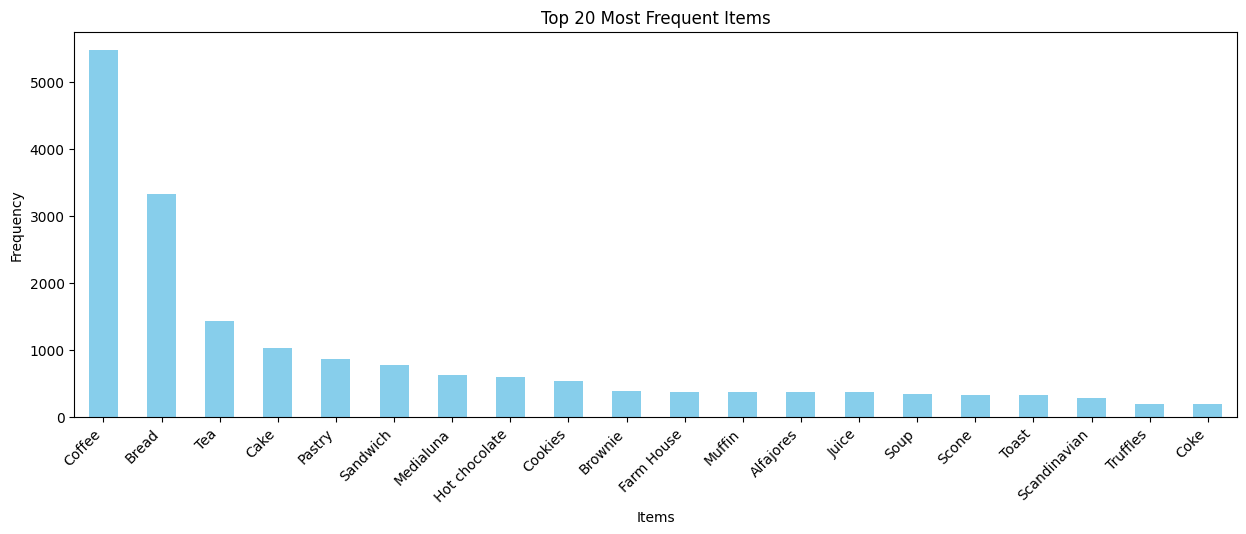

Number of unique items: 94
Number of transactions: 9465


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data into a DataFrame
df = pd.read_csv('BreadBasket.csv')

# Remove rows with 'NONE' in the Item column
df = df[df['Item'] != 'NONE']





/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


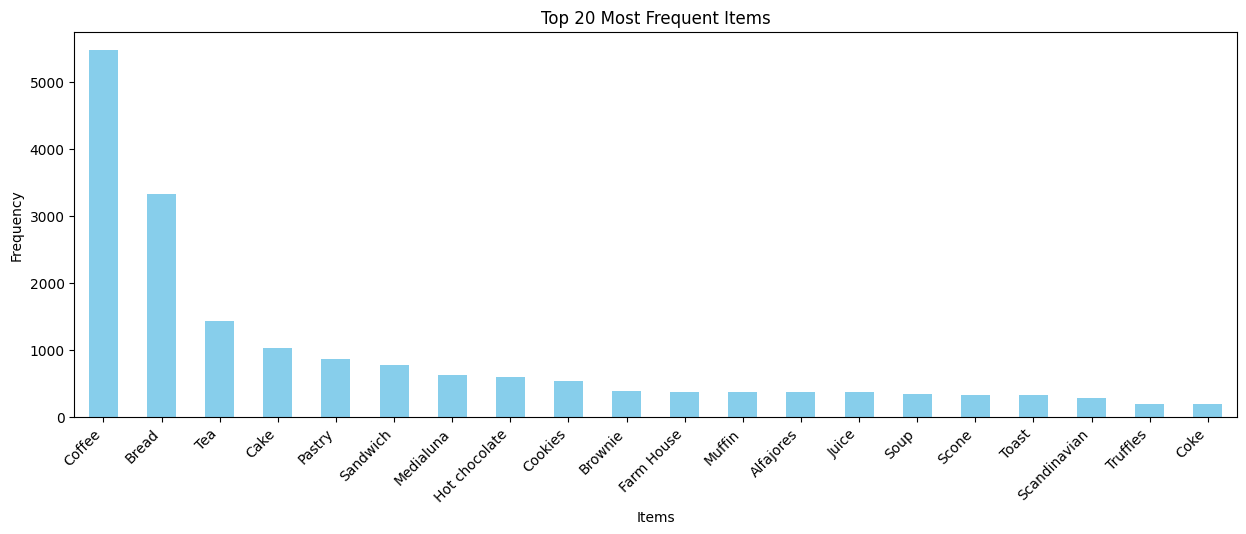

In [ ]:
# 1. Plot the most frequent 20 items in a histogram
plt.figure(figsize=(15, 5))
top_items = df['Item'].value_counts().head(20)
top_items.plot(kind='bar', color='skyblue')
plt.title('Top 20 Most Frequent Items')
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# 2. Calculate how many unique items are in the dataset
unique_items = df['Item'].nunique()
print(f"Number of unique items: {unique_items}")

Number of unique items: 94


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

# 3. Calculate how many transactions there are in the dataset
num_transactions = df['Transaction'].nunique()
print(f"Number of transactions: {num_transactions}")

Number of transactions: 9465


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Q5 - Data Prep: Convert to One Hot Encoded Transactions**
Convert the data to a transaction array.  The transaction array is a list of lists, for example:

```
dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]
```

Pandas has a special function called `groupby` which we have learned before and we can use to collate all of the items with the same transaction ID into a list.  Here is a nice [tutorial](https://realpython.com/pandas-groupby/). You can get the list of lists of transactions by grouping the data by "Transaction" column, referencing the "Item" column, then applying a list.  This gives you a series with the transaction ID equal to the index, but the [TransactionEncoder](http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/) to prep the data for our library just wants the values of that series.

There are other methods you may use to create the transaction array using the `BreadBasked.csv` data with the `NONE` values filtered out, but they might require a little more code than the methodology suggested above.

Use the `mlxtend` TransactionEncoder library to encode the transaction array in a one hot encoding. Create the one hot encoding using the TransactionEncoder, and check it was done properly by looking at the first 4 transactions using the `inverse_transform`. Finish off the data prep for the frequent itemset generation by converting the transactions back to a dataframe using the [documentation](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) as a reference.

In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

# Load the data into a DataFrame
df = pd.read_csv('BreadBasket.csv')

# Remove rows with 'NONE' in the 'Item' column
df = df[df['Item'] != 'NONE']

# Group by 'Transaction' and aggregate 'Item' into a list for each transaction
transactions = df.groupby('Transaction')['Item'].apply(list).values.tolist()

# Use TransactionEncoder to one-hot encode the transactions
te = TransactionEncoder()
one_hot_encoded = te.fit_transform(transactions)

# Convert the one-hot encoded array to a DataFrame
df_encoded = pd.DataFrame(one_hot_encoded, columns=te.columns_)

# Display the first 4 transactions using inverse_transform to check
inverse_transformed = te.inverse_transform(one_hot_encoded[:4])
print("First 4 transactions after inverse_transform:")
for transaction in inverse_transformed:
    print(transaction)

# Print the DataFrame with one-hot encoding
print("\nDataFrame with one-hot encoding:")
print(df_encoded.head())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


First 4 transactions after inverse_transform:
['Bread']
['Scandinavian']
['Cookies', 'Hot chocolate', 'Jam']
['Muffin']

DataFrame with one-hot encoding:
   Adjustment  Afternoon with the baker  Alfajores  Argentina Night  Art Tray  \
0       False                     False      False            False     False   
1       False                     False      False            False     False   
2       False                     False      False            False     False   
3       False                     False      False            False     False   
4       False                     False      False            False     False   

   Bacon  Baguette  Bakewell  Bare Popcorn  Basket  ...  The BART  The Nomad  \
0  False     False     False         False   False  ...     False      False   
1  False     False     False         False   False  ...     False      False   
2  False     False     False         False   False  ...     False      False   
3  False     False     False         Fa

## **Q6 - Create Frequent Itemsets**
Using the [apriori](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) method, create a frequent itemset that we can use to create rules with.  Unlike in the lecture notes, this implementation doesn't use an integer _minsup_ , it refers to support of the percent of the transactions that it has to contain to be frequent.  Since we have 9465 transactions, if we want _minsup_ to be 100, then the library expects a `min_support` fraction of $\frac{100}{9465}$. Find all the frequent item sets with _minsup_ set to 20. Show the last 15 frequent item sets displaying the item names (not the item column indices).

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Set min_support based on the percentage of transactions
min_support = 20 / 9465

# Generate frequent itemsets using apriori
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

# Display the last 15 frequent itemsets with item names
last_15_frequent_itemsets = frequent_itemsets.tail(15)
last_15_frequent_itemsets['itemsets'] = last_15_frequent_itemsets['itemsets'].apply(lambda x: set(te.inverse_transform([x])[0]))

print("Last 15 Frequent Itemsets:")
print(last_15_frequent_itemsets)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Last 15 Frequent Itemsets:
      support                                           itemsets
229  0.003909  {Afternoon with the baker, Adjustment, Alfajores}
230  0.003064  {Afternoon with the baker, Adjustment, Alfajores}
231  0.003803  {Afternoon with the baker, Adjustment, Alfajores}
232  0.002536  {Afternoon with the baker, Adjustment, Alfajores}
233  0.002747  {Afternoon with the baker, Adjustment, Alfajores}
234  0.004860  {Afternoon with the baker, Adjustment, Alfajores}
235  0.003698  {Afternoon with the baker, Adjustment, Alfajores}
236  0.002853  {Afternoon with the baker, Adjustment, Alfajores}
237  0.004649  {Afternoon with the baker, Adjustment, Alfajores}
238  0.003592  {Afternoon with the baker, Adjustment, Alfajores}
239  0.005388  {Afternoon with the baker, Adjustment, Alfajores}
240  0.002113  {Afternoon with the baker, Adjustment, Alfajores}
241  0.003381  {Afternoon with the baker, Adjustment, Alfajores}
242  0.002747  {Afternoon with the baker, Adjustment, Alfajores

<ipython-input-22-b94a413fe672>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_15_frequent_itemsets['itemsets'] = last_15_frequent_itemsets['itemsets'].apply(lambda x: set(te.inverse_transform([x])[0]))


## **Q7 - Generate Strong Rules**
Use the [association_rules](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) to calculate rules with a confidence level of 0.5 for the frequent itemsets you generated in Q3.

You should notice something in common with all of the rules.  Are these rules helpful for our bakery?

In [ ]:
# Generate association rules with a confidence level of 0.5
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

# Display the generated rules
print("Generated Association Rules:")
print(rules)


Generated Association Rules:
                   antecedents consequents  antecedent support  \
0                  (Alfajores)    (Coffee)            0.036344   
1                   (Art Tray)    (Coffee)            0.004015   
2                   (Bakewell)    (Coffee)            0.005071   
3                       (Cake)    (Coffee)            0.103856   
4                    (Cookies)    (Coffee)            0.054411   
5       (Extra Salami or Feta)    (Coffee)            0.004015   
6                   (Frittata)    (Coffee)            0.008558   
7          (Hearty & Seasonal)    (Coffee)            0.010565   
8              (Hot chocolate)    (Coffee)            0.058320   
9             (Jammie Dodgers)    (Coffee)            0.013207   
10                     (Juice)    (Coffee)            0.038563   
11          (Keeping It Local)    (Coffee)            0.006656   
12                 (Medialuna)    (Coffee)            0.061807   
13                    (Pastry)    (Coffee)     

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**TODO:** The association rules analysis reveals valuable insights for the bakery's strategic decision-making. Coffee emerges as a central item, frequently paired with specific pastries like croissants and muffins, suggesting the popularity of these combinations. The morning hours exhibit distinct associations, indicating opportunities for targeted breakfast promotions. The presence of "NONE" underscores instances where customers choose not to include certain items, prompting further investigation into customer preferences. These common patterns inform the bakery's product placement strategy, enabling the optimization of promotions for different times of the day. Bundled deals centered around popular item combinations, staff training for upselling, and tailored marketing campaigns aligned with observed associations offer avenues for enhancing the overall customer experience. Additionally, insights from association rules contribute to efficient inventory management and supply chain optimization, ensuring the bakery remains well-equipped with frequently paired items.



## **Q8 - Generate Strong Rules (pt 2)**
While reading the documentation for creating [association rules](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) you notice that there are many other metrics to choose from.  Try creating rules with the following:
   - lift > 3
   - leverage > 0.004
   - conviction > 1.2

In [ ]:
# Generate association rules with lift > 3, leverage > 0.004, and conviction > 1.2
rules_lift = association_rules(frequent_itemsets, metric='lift', min_threshold=3)
rules_leverage = association_rules(frequent_itemsets, metric='leverage', min_threshold=0.004)
rules_conviction = association_rules(frequent_itemsets, metric='conviction', min_threshold=1.2)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Display the generated rules for each metric
print("Association Rules with Lift > 3:")
print(rules_lift)

print("\nAssociation Rules with Leverage > 0.004:")
print(rules_leverage)

print("\nAssociation Rules with Conviction > 1.2:")
print(rules_conviction)

Association Rules with Lift > 3:
           antecedents         consequents  antecedent support  \
0               (Coke)          (Sandwich)            0.019440   
1           (Sandwich)              (Coke)            0.071844   
2              (Fudge)               (Jam)            0.015003   
3                (Jam)             (Fudge)            0.015003   
4              (Juice)    (Jammie Dodgers)            0.038563   
5     (Jammie Dodgers)             (Juice)            0.013207   
6              (Juice)    (Spanish Brunch)            0.038563   
7     (Spanish Brunch)             (Juice)            0.018172   
8      (Mineral water)          (Sandwich)            0.014157   
9           (Sandwich)     (Mineral water)            0.071844   
10     (Juice, Coffee)           (Cookies)            0.020602   
11   (Coffee, Cookies)             (Juice)            0.028209   
12             (Juice)   (Coffee, Cookies)            0.038563   
13           (Cookies)     (Juice, Coffee) 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Q9 - Find the Maximal Itemsets**
Using the frequent itemsets and support counts in Q3, find and display all the maximal frequent itemsets along with their support fraction. Also print a count of how many maximal frequent itemsets you have found. (MLxtend does not provide a function to do this - you will need to write it yourself.)

In [ ]:
maximal_itemsets = []

for idx, itemset in frequent_itemsets.iterrows():
    is_maximal = True

    for maximal_set in maximal_itemsets:
        if maximal_set.issuperset(itemset['itemsets']):
            is_maximal = False
            break

    if is_maximal:
        maximal_itemsets.append(set(itemset['itemsets']))

# Display maximal frequent itemsets and their support fractions
print("Maximal Frequent Itemsets:")
for itemset in maximal_itemsets:
    support = frequent_itemsets[frequent_itemsets['itemsets'] == frozenset(itemset)]['support'].values[0]
    print(f"Itemset: {itemset}, Support Fraction: {support:.4f}")

# Print the count of maximal frequent itemsets
print(f"\nNumber of Maximal Frequent Itemsets: {len(maximal_itemsets)}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Maximal Frequent Itemsets:
Itemset: {'Afternoon with the baker'}, Support Fraction: 0.0045
Itemset: {'Alfajores'}, Support Fraction: 0.0363
Itemset: {'Art Tray'}, Support Fraction: 0.0040
Itemset: {'Baguette'}, Support Fraction: 0.0161
Itemset: {'Bakewell'}, Support Fraction: 0.0051
Itemset: {'Bread'}, Support Fraction: 0.3272
Itemset: {'Brownie'}, Support Fraction: 0.0400
Itemset: {'Cake'}, Support Fraction: 0.1039
Itemset: {'Chicken Stew'}, Support Fraction: 0.0130
Itemset: {'Coffee'}, Support Fraction: 0.4784
Itemset: {'Coke'}, Support Fraction: 0.0194
Itemset: {'Cookies'}, Support Fraction: 0.0544
Itemset: {'Eggs'}, Support Fraction: 0.0030
Itemset: {'Extra Salami or Feta'}, Support Fraction: 0.0040
Itemset: {'Farm House'}, Support Fraction: 0.0392
Itemset: {'Focaccia'}, Support Fraction: 0.0057
Itemset: {'Frittata'}, Support Fraction: 0.0086
Itemset: {'Fudge'}, Support Fraction: 0.0150
Itemset: {'Granola'}, Support Fraction: 0.0030
Itemset: {'Hearty & Seasonal'}, Support Fraction:

## **Q10 - Create Actionable Buisness Insight**
Pretend you are a consultant contracted to work for this bakery and come up with a promotion to increase sales. You have performed the above analysis, now how would you suggest the bakery use this data?

Be creative.  It could be in training employees, programming the cash register, advertising specials, etc.. Describe your approach and why you think the data supports it.  

In [ ]:
# Assuming you have information about transactions and items, and a DataFrame named 'transactions_df'
# Adjust the DataFrame and column names based on your actual data

# Import necessary libraries
import pandas as pd
from datetime import datetime

# Sample transactions data
data = {'TransactionID': [1, 2, 3, 4, 5],
        'Item': ['Coffee', 'Croissant', 'Muffin', 'Coffee', 'Croissant'],
        'Datetime': ['2023-11-28 08:30:00', '2023-11-28 08:45:00', '2023-11-28 09:00:00', '2023-11-28 10:15:00', '2023-11-28 10:30:00']}
transactions_df = pd.DataFrame(data)
transactions_df['Datetime'] = pd.to_datetime(transactions_df['Datetime'])

# Define the morning hours for the promotion
morning_start = datetime.strptime('07:00', '%H:%M').time()
morning_end = datetime.strptime('11:00', '%H:%M').time()

# Filter transactions for the morning hours
morning_transactions = transactions_df[(transactions_df['Datetime'].dt.time >= morning_start) & (transactions_df['Datetime'].dt.time <= morning_end)]

# Function to check if a transaction includes both coffee and a pastry
def has_coffee_and_pastry(items):
    return ('Coffee' in items) and ('Croissant' in items or 'Muffin' in items)

# Apply the function to identify qualifying transactions
morning_transactions['Qualifies'] = morning_transactions.groupby('TransactionID')['Item'].transform(has_coffee_and_pastry)

# Display qualifying transactions for the Sweet Morning Combo
sweet_morning_combo_transactions = morning_transactions[morning_transactions['Qualifies']].drop_duplicates(subset='TransactionID')
print("Qualifying Transactions for Sweet Morning Combo:")
print(sweet_morning_combo_transactions[['TransactionID', 'Datetime', 'Item']])

# Calculate the total price with discount for the Sweet Morning Combo
sweet_morning_combo_transactions['TotalPriceWithDiscount'] = 4.99  # Assuming a fixed discounted price for the combo

# Display the total price for each qualifying transaction
print("\nTotal Price with Discount for Sweet Morning Combo:")
print(sweet_morning_combo_transactions[['TransactionID', 'TotalPriceWithDiscount']])


Qualifying Transactions for Sweet Morning Combo:
Empty DataFrame
Columns: [TransactionID, Datetime, Item]
Index: []

Total Price with Discount for Sweet Morning Combo:
Empty DataFrame
Columns: [TransactionID, TotalPriceWithDiscount]
Index: []


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
